# Light Schrödinger Bridge Night to Day Domain Transform

This notebooks trains the LightSB model using the AutoencoderKL latents we generated. It will perform a grid search over the n_potentials, is_diagonal and epsilon parameters to get the best performing model.

Next, it performs a transformation on the night validation set. Finally, we decode these latents back into images using the encoder and save them separately to the data folder.

## Imports

In [17]:
import os, sys

# if colab, mount drive and get the git repo
if 'google.colab' in sys.modules:
    from google.colab import drive
    print(os.getcwd())
    drive.mount('/content/drive')
    !git clone --recurse-submodules https://github.com/jsluijter02/LightSB_YOLO

    # Append LightSB_YOLO path
    sys.path.append(os.path.join(os.getcwd(), 'LightSB_YOLO'))

    ## TODO: 

# otherwise local path append
else:
    sys.path.append(os.path.dirname(os.getcwd()))

In [18]:
import numpy as np
np.random.seed(0)
from argparse import Namespace
import copy
import torch
import diffusers
from datetime import date

from scripts.utils import dirs
dirs.add_LIGHTSB_to_PATH()

from scripts.models.autoencoderkl import AutoencoderKL_BDD
from scripts.models.lightsb import LightSB_BDD
from scripts.evals.FID import latent_FID_score, image_FID_score
from scripts.utils import img
from scripts.utils.device import get_device

## Encoder Model

In [19]:
encoder = AutoencoderKL_BDD()

## Load Data

In [20]:
data_dir = dirs.get_data_dir()
latent_dir = os.path.join(data_dir, "encodings")

# Only save Val_night file names -> others are redundant
train_day_latents, _  = encoder.load_latents(os.path.join(latent_dir, "train_day.npz"))
print(train_day_latents.shape)

train_night_latents, _ = encoder.load_latents(os.path.join(latent_dir, "train_night.npz"))
print("train_night_latents shape: ", train_night_latents.shape)

val_day_latents, _ = encoder.load_latents(os.path.join(latent_dir, "val_day.npz"))
print("val_day_latents shape: ", val_day_latents.shape)

val_night_latents, val_night_filenames = encoder.load_latents(os.path.join(latent_dir, "val_night.npz"))
print("val_night_latents shape: ", val_night_latents.shape)
print("val_night_filenames length: ", len(val_night_filenames))

np_data = {"train_day": train_day_latents, 
           "train_night": train_night_latents, 
           "val_day": val_day_latents, 
           "val_night": val_night_latents}

(36800, 2304)
train_night_latents shape:  (28028, 2304)
val_day_latents shape:  (5258, 2304)
val_night_latents shape:  (3929, 2304)
val_night_filenames length:  3929


## Train SB with a Grid Search + Val Set Evaluation
To get a sense of parameter's effectiveness on the transformation, this step performs a grid search and saves the best parameters and state dictionary.

Evaluation method: FID on latents.

Due to computational and time constraints, it is not possible to transform ALL images six times and produce FID-scores, so a latent-based proxy is taken to determine final LightSB model parameters. FID metric on images will be taken of the final image set.

This is different from actual FID metric, as this takes the metric on features learned from a CNN.

Additionally, downstream, the mAP of the YOLOPX algorithm will determine this method's succesfullness as a preprocessing step.

### Grid Search Data
50/50 Split of the train set, for train/val. This, as to not overfit on the val set.

In [9]:
np.random.seed(0)

night = np_data['train_night']
day = np_data['train_day']

len_night = len(night)
len_day = len(day)

night_train_indices = img.sample_indices(length=len_night, how_many=int(len_night*0.8))
night_val_indices = list(set(range(len_night)) - set(night_train_indices))

day_train_indices = img.sample_indices(length=len_day, how_many=int(len_day*0.8))
day_val_indices = list(set(range(len_day)) - set(day_train_indices))

gs_data = {"train_day": train_day_latents[day_train_indices], 
           "train_night": train_night_latents[night_train_indices], 
           "val_day": train_day_latents[day_val_indices], 
           "val_night": train_night_latents[night_val_indices]}

print(gs_data['train_night'].shape)
print(gs_data['train_day'].shape)
print(gs_data['val_night'].shape)
print(gs_data['val_day'].shape)

(22422, 2304)
(29440, 2304)
(5606, 2304)
(7360, 2304)


### Grid Search Parameters

In [10]:
# GS 1
epsilons = [0.01, 0.1, 0.5]
n_potentials = [10, 20]
max_steps = [1000, 10000, 50000]
# Results: 0.01, 20, 50000, suggesting epsilon is good, but more potentials and steps are warranted.
# Interestingly, at 1000 steps the model just collapses to a day image

# GS 2: extra pot, extra steps
epsilons = [0.01]
n_potentials = [30, 50]
max_steps = [50000, 100000]

# Did not actually improve, so 
# GS 3
epsilons = [0.01]
n_potentials = [20]
max_steps = [100000]


### Grid Search Setup

[ 731 1569 5081 3646 3771]
latents shape:  torch.Size([5, 2304])
reshaped latents shape:  torch.Size([5, 4, 18, 32])


100%|██████████| 1/1 [00:00<00:00,  3.43it/s]


decoded latents shape:  torch.Size([5, 3, 144, 256])


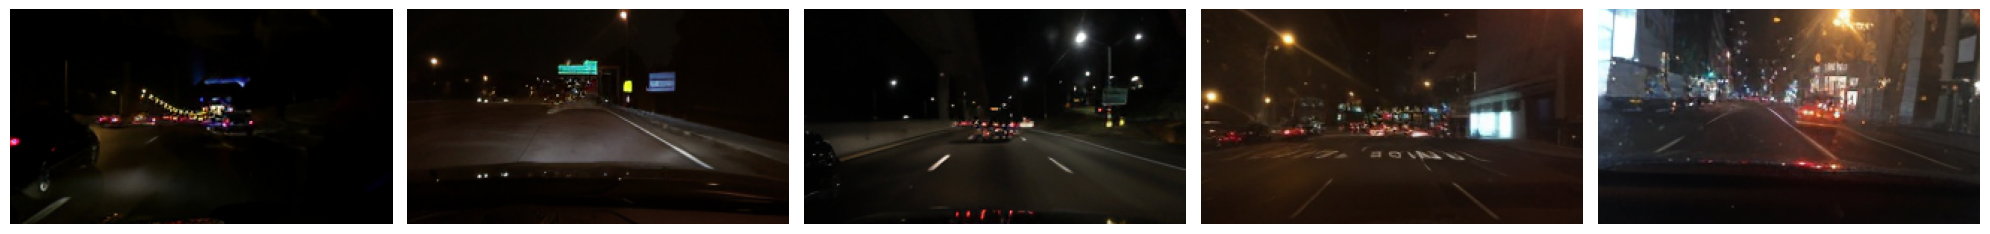

In [21]:
args = Namespace()

models = {}
fid_scores = {}

runs_path = os.path.join(dirs.get_base_dir(), "results", "5_yolopx_lightsb_night", "LightSB_GridSearch")
os.makedirs(runs_path, exist_ok=True)

# indices for the images to plot each gs run, to have a visual reference of the transformation qual
sample_indices = img.sample_indices(len(gs_data['val_night']), how_many=5)
print(sample_indices)

gt_latents = gs_data['val_night'][sample_indices]
gt_decoded = encoder.decode_latents(gt_latents)
gt_imgs = diffusers.utils.pt_to_pil(gt_decoded)

img.plot_samples(gt_imgs, square=False)

for i,gt in enumerate(gt_imgs):
    gt.save(os.path.join(dirs.get_base_dir(), "results", "5_yolopx_lightsb_night", f"gt_{i}.jpg"))


### Baseline FID of Val Night and Val Day

In [12]:
vn = torch.as_tensor(gs_data['val_night'], device=get_device())
vd = torch.as_tensor(gs_data['val_day'], device=get_device())
print(vn.size())
print(vd.size())
baseline_FID = latent_FID_score(vd,vn)
print(baseline_FID)

torch.Size([5606, 2304])
torch.Size([7360, 2304])
40336.38812484657


### Grid Search Loop + Internal Val Set Eval

In [8]:
def completed(epsilon, max_steps, n_potentials):
    return os.path.exists(os.path.join(runs_path, f'LightSB_eps{epsilon}_pot{n_potentials}_step{max_steps}'))

Started process for:  100000   0.01   20
Reloading model
Reloaded model
Training model


100%|██████████| 100000/100000 [17:14<00:00, 96.67it/s]


Trained model
Transforming Validation Latents
FID-score on latents:  6652.608070151942
latents shape:  torch.Size([5, 2304])
reshaped latents shape:  torch.Size([5, 4, 18, 32])


100%|██████████| 1/1 [00:00<00:00,  2.86it/s]


decoded latents shape:  torch.Size([5, 3, 144, 256])


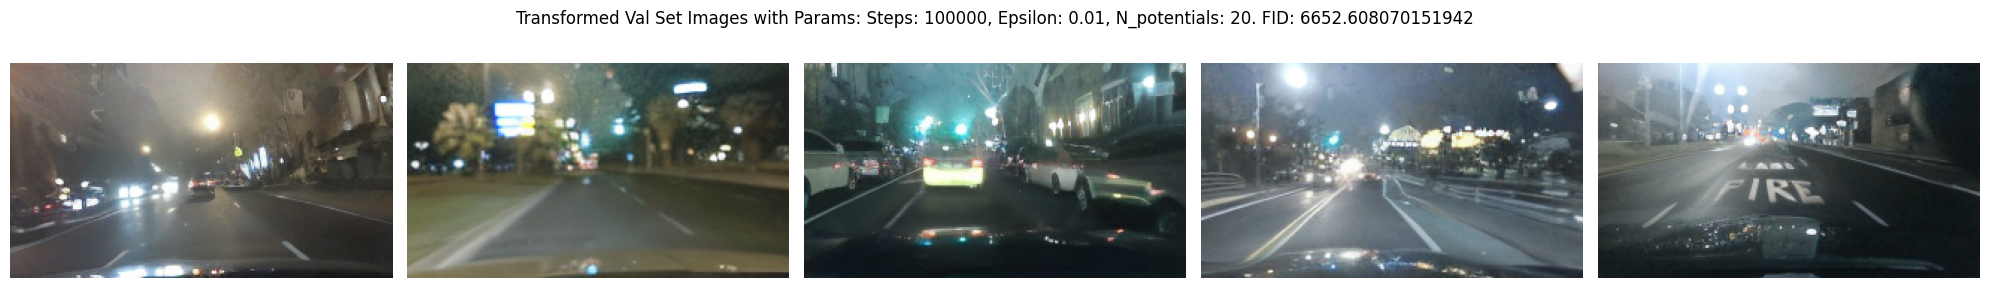

In [9]:
for eps in epsilons:
    for potential in n_potentials:
        for steps in max_steps:

            if completed(eps, steps, potential):
                print(f"Already completed for eps: {eps}, steps: {steps}, potential: {potential}")
                continue

            print("Started process for: ", steps, " ", eps, " ", potential)

            # to reduce training time, reduce steps to 1000
            args.MAX_STEPS = steps
            args.EPSILON = eps
            args.N_POTENTIALS = potential

            print("Reloading model")
            gs_config = LightSB_BDD.update_config(args=args)
            gs_sb = LightSB_BDD(gs_config, np_data=gs_data)
            print("Reloaded model")

            print("Training model")
            gs_sb.train()
            print("Trained model")

            print("Transforming Validation Latents")
            transformed = gs_sb.transform(gs_sb.X_test)
            fid = latent_FID_score(transformed, gs_sb.Y_test)
            print("FID-score on latents: ", fid)

            save = {
                "fid": fid,
                "max_steps": steps,
                "epsilon": eps,
                "n_potentials": potential
            }

            save_name = f'LightSB_eps{eps}_pot{potential}_step{steps}'
            params_path = os.path.join(runs_path, save_name, "params.npy")
            os.makedirs(os.path.dirname(params_path), exist_ok=True)
            np.save(params_path, save, allow_pickle=True)

            sample_imgs = diffusers.utils.pt_to_pil(encoder.decode_latents(transformed[sample_indices]))
            img.plot_samples(sample_imgs, 
                             title=f'Transformed Val Set Images with Params: Steps: {steps}, Epsilon: {eps}, N_potentials: {potential}. FID: {fid}', 
                             square=False)
            
            for i, image in enumerate(sample_imgs):
                image.save(os.path.join(runs_path, save_name, f"{i}.png"))

            

## Transform Val Images with Best Model

### Find Best Model

In [22]:
combinations = os.listdir(runs_path)
best = {}

for combos in combinations:
    data = np.load(os.path.join(runs_path, combos, "params.npy"), allow_pickle=True).item()
    if best == {} or data['fid'] < best['fid']:
        best = data

print("Best: ", best)

results = []
for combos in combinations:
    data = np.load(os.path.join(runs_path, combos, "params.npy"), allow_pickle=True).item()
    results.append(data)

results = sorted(results, key=lambda x: x['max_steps'])
for res in results:
    print(res)


Best:  {'fid': 6621.887885087175, 'max_steps': 50000, 'epsilon': 0.01, 'n_potentials': 20}
{'fid': 45893.044976372825, 'max_steps': 1000, 'epsilon': 0.5, 'n_potentials': 20}
{'fid': 44530.59502725859, 'max_steps': 1000, 'epsilon': 0.01, 'n_potentials': 20}
{'fid': 43977.192597337926, 'max_steps': 1000, 'epsilon': 0.1, 'n_potentials': 20}
{'fid': 47114.43981969212, 'max_steps': 1000, 'epsilon': 0.1, 'n_potentials': 10}
{'fid': 51063.083565785055, 'max_steps': 1000, 'epsilon': 0.01, 'n_potentials': 10}
{'fid': 45271.982488075686, 'max_steps': 1000, 'epsilon': 0.5, 'n_potentials': 10}
{'fid': 8546.978927973663, 'max_steps': 10000, 'epsilon': 0.1, 'n_potentials': 20}
{'fid': 8280.210988424844, 'max_steps': 10000, 'epsilon': 0.5, 'n_potentials': 10}
{'fid': 9384.44194338839, 'max_steps': 10000, 'epsilon': 0.01, 'n_potentials': 10}
{'fid': 8619.363638957246, 'max_steps': 10000, 'epsilon': 0.01, 'n_potentials': 20}
{'fid': 8307.659623386146, 'max_steps': 10000, 'epsilon': 0.5, 'n_potentials':

### Load Best Model

In [23]:
best_cfg = LightSB_BDD.standard_config()
best_cfg.MODEL.EPSILON = best["epsilon"]
best_cfg.MODEL.N_POTENTIALS = best["n_potentials"]
best_cfg.MAX_STEPS = best["max_steps"]

print(best_cfg)

best_sb = LightSB_BDD(config=best_cfg, np_data=np_data)

CONTINUE: -1
DIM: 2304
EXP_NAME: LightSB_night_TO_daytime_EPSILON_0.1
INPUT_DATA: night
MAX_STEPS: 50000
MODEL:
  BATCH_SIZE: 128
  D_GRADIENT_MAX_NORM: inf
  D_LR: 0.001
  EPSILON: 0.01
  INIT_BY_SAMPLES: True
  IS_DIAGONAL: True
  N_POTENTIALS: 20
  SAMPLING_BATCH_SIZE: 128
OUTPUT_PATH: ../checkpoints/LightSB_night_TO_daytime_EPSILON_0.1
OUTPUT_SEED: 195935983
TARGET_DATA: daytime


### Train Best Model

In [ ]:
best_sb.train()

100%|██████████| 50000/50000 [13:05<00:00, 63.62it/s]


### Transform and Decode Real Validation Night Set with Best Model

In [24]:
best_transformed = best_sb.transform(best_sb.X_test)
#np.save(os.path.join(dirs.get_data_dir(), 'encodings', "LightSB_transformed"), best_transformed.cpu())

In [ ]:
best_transformed = torch.as_tensor(np.load(os.path.join(dirs.get_data_dir(), 'encodings', "LightSB_transformed.npy")), device=get_device())
print(best_transformed.shape)
decoded = encoder.decode_latents(best_transformed, batch_size=8)

torch.Size([3929, 2304])
latents shape:  torch.Size([3929, 2304])
reshaped latents shape:  torch.Size([3929, 4, 18, 32])


100%|██████████| 492/492 [06:31<00:00,  1.26it/s]

decoded latents shape:  torch.Size([3929, 3, 144, 256])


In [ ]:
np.save(os.path.join(dirs.get_data_dir(), 'encodings', "LightSB_decoded.npy"), decoded.cpu())

## Save Images to Folder

In [ ]:
decoded = torch.as_tensor(np.load(os.path.join(dirs.get_data_dir(), "encodings",  "LightSB_decoded.npy")), device=get_device())
print(decoded.shape)
print(decoded.min(), decoded.max())

torch.Size([3929, 3, 144, 256])
tensor(-1.5068, device='mps:0') tensor(1.7297, device='mps:0')


In [ ]:
encoder.save_imgs(decoded, filenames=val_night_filenames, folder_name="images_LightSB", split="val")

3929it [00:22, 173.21it/s]
